In [1]:
import os
import pandas as pd
import fuzzymatcher
from mplsoccer.pitch import Pitch, VerticalPitch
import matplotlib.pyplot as plt
import shapely.geometry as geom
import numpy as np

Load the data

In [2]:
cwd = os.getcwd()
STATSBOMB_SHOTS = os.path.join(cwd, 'data', 'statsbomb', 'shots.parquet')
WYSCOUT_SHOTS = os.path.join(cwd, 'data', 'wyscout', 'shots.parquet')
FREEZE_FEATURES = os.path.join(cwd, 'data', 'statsbomb', 'freeze_features.parquet')
df_statsbomb_shots = pd.read_parquet(STATSBOMB_SHOTS)
df_wyscout_shots = pd.read_parquet(WYSCOUT_SHOTS)
df_freeze_frame = pd.read_parquet(FREEZE_FEATURES)

Remove three shots without player info

In [3]:
df_wyscout_shots = df_wyscout_shots[df_wyscout_shots.player_id.notnull()].copy()

Get a unique team id by combining the datasets and using a fuzzy match on team name

In [4]:
cols = ['team_id', 'team_name', 'competition_gender']
a = df_wyscout_shots[cols].drop_duplicates('team_id', keep='last').rename({'team_id': 'wyscout_team_id'}, axis=1).copy()
b = df_statsbomb_shots[cols].drop_duplicates('team_id', keep='last').rename({'team_id': 'statsbomb_team_id'}, axis=1).copy()
team_match = fuzzymatcher.fuzzy_left_join(a,
                                          b,
                                          left_on=['team_name', 'competition_gender'],
                                          right_on=['team_name', 'competition_gender'],
                                          left_id_col='wyscout_team_id',
                                          right_id_col='statsbomb_team_id')
team_match = team_match[(team_match.best_match_score > 0.02) & (team_match.competition_gender_right == 'male')].copy()
team_match = (team_match[['wyscout_team_id', 'statsbomb_team_id', 'competition_gender_right', 'team_name_right']]
              .rename({'team_name_right': 'team_name', 'competition_gender_right': 'competition_gender'}, axis=1)
              .copy())
df_team = pd.concat([a[~a.wyscout_team_id.isin(team_match.wyscout_team_id)],
                     b[~b.statsbomb_team_id.isin(team_match.statsbomb_team_id)],
                     team_match])
df_team.reset_index(drop=True, inplace=True)
df_team.index.name = 'team_id'
df_team.reset_index(inplace=True)

Add the unique team_id/ name to the datasets

In [5]:
# wyscout
a = df_team[['team_id', 'wyscout_team_id', 'team_name']].copy()
df_wyscout_shots.rename({'team_id': 'wyscout_team_id'}, axis=1, inplace=True)
df_wyscout_shots.drop('team_name', axis=1, inplace=True)
df_wyscout_shots = df_wyscout_shots.merge(a, how='left', on='wyscout_team_id')
# statsbomb
b = df_team[['team_id', 'statsbomb_team_id', 'team_name']].copy()
df_statsbomb_shots.rename({'team_id': 'statsbomb_team_id'}, axis=1, inplace=True)
df_statsbomb_shots.drop('team_name', axis=1, inplace=True)
df_statsbomb_shots = df_statsbomb_shots.merge(b, how='left', on='statsbomb_team_id')

Get a unique player id

In [6]:
# get a dataframe of statsbomb players
cols = ['player_id', 'team_id', 'team_name', 'firstName', 'middleName', 'lastName', 'Name', 'competition_gender']
statsbomb_players = df_statsbomb_shots[cols].drop_duplicates('player_id').copy()
statsbomb_players.rename({'player_id': 'player_id_statsbomb'}, axis=1, inplace=True)
# get a dataframe of wyscout players
wyscout_players = df_wyscout_shots[cols].drop_duplicates('player_id').copy()
wyscout_players.rename({'player_id': 'player_id_wyscout'}, axis=1, inplace=True)

In [7]:
# merge the two datasets: exact match on names
exact_match = wyscout_players.merge(statsbomb_players, how='inner', 
                                    on=['firstName', 'middleName', 'lastName', 'Name'],
                                    suffixes=['_wyscout', '_statsbomb'])
print('Check no duplicates:', exact_match.player_id_wyscout.duplicated().sum(), 
      exact_match.player_id_statsbomb.duplicated().sum())
exact_match = exact_match[['player_id_wyscout', 'player_id_statsbomb', 'firstName', 'middleName', 'lastName', 'Name']].copy()

Check no duplicates: 0 0


In [8]:
# for the unmatched use a fuzzy match to match on names
not_matched_statsbomb = statsbomb_players[~statsbomb_players.player_id_statsbomb.isin(exact_match.player_id_statsbomb)].copy()
not_matched_wyscout = wyscout_players[~wyscout_players.player_id_wyscout.isin(exact_match.player_id_wyscout)].copy()
fuzzy_match = fuzzymatcher.fuzzy_left_join(not_matched_wyscout,
                                           not_matched_statsbomb,
                                           left_on=['Name'],
                                           right_on=['Name'],
                                           left_id_col='player_id_wyscout',
                                           right_id_col='player_id_statsbomb')
fuzzy_match.sort_values('best_match_score', ascending=False, inplace=True)
fuzzy_match.drop_duplicates('player_id_wyscout', keep='first', inplace=True)
fuzzy_match.drop_duplicates('player_id_statsbomb', keep='first', inplace=True)
# drop some dodgy matches just above the threshold (hand checked)
fuzzy_match = fuzzy_match[(fuzzy_match.best_match_score > 0.25)  & 
                          (fuzzy_match.competition_gender_left == fuzzy_match.competition_gender_right) & 
                          (~fuzzy_match.player_id_statsbomb.isin([23804, 40366, 40257]))].copy()

In [9]:
# concatenate all the matches
fuzzy_match = fuzzy_match[['player_id_wyscout', 'player_id_statsbomb', 'firstName_right',
                           'middleName_right', 'lastName_right', 'Name_right']].copy()
fuzzy_match.rename({'firstName_right': 'firstName', 'middleName_right': 'middleName',
                    'lastName_right': 'lastName', 'Name_right': 'Name'}, axis=1, inplace=True)
matches = pd.concat([fuzzy_match, exact_match])
# add the non-matches
not_matched_wyscout = wyscout_players[~wyscout_players.player_id_wyscout.isin(matches.player_id_wyscout)].copy()
not_matched_statsbomb = statsbomb_players[~statsbomb_players.player_id_statsbomb.isin(matches.player_id_statsbomb)].copy()
all_players = pd.concat([matches, not_matched_wyscout, not_matched_statsbomb])
all_players.drop(['team_id', 'team_name', 'competition_gender'], axis=1, inplace=True)
all_players.reset_index(drop=True, inplace=True)
all_players.index.name = 'player_id'
all_players.reset_index(inplace=True)

Add unique player id/ Names to datasets

In [10]:
# merge statsbomb
df_statsbomb_shots.drop(['firstName', 'middleName', 'lastName', 'Name'], axis=1, inplace=True)
df_statsbomb_shots.rename({'player_id': 'player_id_statsbomb'}, axis=1, inplace=True)
df_statsbomb_shots = df_statsbomb_shots.merge(all_players.drop('player_id_wyscout', axis=1),
                                              on='player_id_statsbomb', how='left')
# merge wyscout
df_wyscout_shots.drop(['firstName', 'middleName', 'lastName', 'Name'], axis=1, inplace=True)
df_wyscout_shots.rename({'player_id': 'player_id_wyscout'}, axis=1, inplace=True)
df_wyscout_shots = df_wyscout_shots.merge(all_players.drop('player_id_statsbomb', axis=1),
                                          on='player_id_wyscout', how='left')

Merge freeze frame features

In [11]:
df_statsbomb_shots = df_statsbomb_shots.merge(df_freeze_frame, on='id', how='left')
df_statsbomb_shots

,match_id,id,eventSec,period,goal,statsbomb_team_id,player_id_statsbomb,shot_type_name,x,y,...,player_id,firstName,middleName,lastName,Name,area_shot,area_goal,n_angle,goalkeeper_x,goalkeeper_y
0,68357,25875da2-cf9d-461f-a423-ef7806fa3603,0.400,5,True,852.0,10386.0,penalty,94.5875,33.830,...,2235,Caroline,Graham,Hansen,Caroline Graham Hansen,NaN,NaN,NaN,NaN,NaN
1,18243,85011ca9-6869-4a82-8101-8db06eb88d21,0.777,5,True,220.0,5200.0,penalty,95.3750,33.150,...,53,Lucas,Vázquez,Iglesias,Lucas Vázquez Iglesias,NaN,NaN,NaN,NaN,NaN
2,2302764,2a8656c0-311f-4abc-b097-be10d19c3e0b,1.731,5,False,243.0,34385.0,penalty,94.6750,33.915,...,2236,Claudio,,Santos,Claudio Santos,NaN,NaN,NaN,NaN,NaN
3,7582,d077fefd-b6be-4992-92c8-ae347b6ab2f5,5.627,5,True,772.0,5216.0,penalty,95.3750,33.150,...,269,Andrés,Iniesta,Luján,Andrés Iniesta Luján,NaN,NaN,NaN,NaN,NaN
4,7581,539170ab-d9f1-47e6-b4c4-d9a5fbf9599f,7.413,5,False,776.0,3043.0,penalty,94.5000,34.000,...,49,Christian,Dannemann,Eriksen,Christian Dannemann Eriksen,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22664,7567,cee57292-f34a-4595-bb06-f58bafb561ed,3187.680,2,False,770.0,5572.0,throw_in,92.7500,38.250,...,87,Mats,,Hummels,Mats Hummels,1162.559634,21.226145,6.0,117.0,38.0
22665,7567,60c04bc0-2d71-4bdd-9e54-a095419682a3,3221.093,2,False,770.0,5572.0,open_play,98.8750,34.850,...,87,Mats,,Hummels,Mats Hummels,8.472222,24.875000,1.0,117.0,39.0
22666,69163,322e37fb-a234-47e1-9bbf-1416b94160d5,3227.196,2,False,1206.0,15290.0,corner,92.2250,42.330,...,3113,Ashley,,Lawrence,Ashley Lawrence,23.166178,15.500731,8.0,115.0,36.4
22667,69163,be44b16b-63a0-446a-8517-00d51b93c403,3230.227,2,False,1206.0,15180.0,corner,85.4875,38.165,...,2920,Sophie,,Schmidt,Sophie Schmidt,14.746298,63.918341,7.0,118.9,39.2


Concatenate shot datasets

In [12]:
df_statsbomb_shots['dataset'] = 'statsbomb'
df_wyscout_shots.rename({'id': 'wyscout_id'}, axis=1, inplace=True)
df_wyscout_shots['dataset'] = 'wyscout'
df_statsbomb_shots.rename({'id': 'statsbomb_id'}, axis=1, inplace=True)
df_all_shots = pd.concat([df_statsbomb_shots, df_wyscout_shots], axis=0)
df_all_shots

,match_id,statsbomb_id,eventSec,period,goal,statsbomb_team_id,player_id_statsbomb,shot_type_name,x,y,...,area_shot,area_goal,n_angle,goalkeeper_x,goalkeeper_y,dataset,wyscout_id,wyscout_team_id,player_id_wyscout,smart_pass
0,68357,25875da2-cf9d-461f-a423-ef7806fa3603,0.400000,5.0,True,852.0,10386.0,penalty,94.5875,33.830,...,NaN,NaN,NaN,NaN,NaN,statsbomb,NaN,NaN,NaN,NaN
1,18243,85011ca9-6869-4a82-8101-8db06eb88d21,0.777000,5.0,True,220.0,5200.0,penalty,95.3750,33.150,...,NaN,NaN,NaN,NaN,NaN,statsbomb,NaN,NaN,NaN,NaN
2,2302764,2a8656c0-311f-4abc-b097-be10d19c3e0b,1.731000,5.0,False,243.0,34385.0,penalty,94.6750,33.915,...,NaN,NaN,NaN,NaN,NaN,statsbomb,NaN,NaN,NaN,NaN
3,7582,d077fefd-b6be-4992-92c8-ae347b6ab2f5,5.627000,5.0,True,772.0,5216.0,penalty,95.3750,33.150,...,NaN,NaN,NaN,NaN,NaN,statsbomb,NaN,NaN,NaN,NaN
4,7581,539170ab-d9f1-47e6-b4c4-d9a5fbf9599f,7.413000,5.0,False,776.0,3043.0,penalty,94.5000,34.000,...,NaN,NaN,NaN,NaN,NaN,statsbomb,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43406,2499739,NaN,3310.186437,2.0,False,NaN,NaN,throw_in,91.3500,46.920,...,NaN,NaN,NaN,NaN,NaN,wyscout,182137485.0,1659.0,9277.0,None
43407,2499820,NaN,3307.255167,2.0,False,NaN,NaN,penalty,93.4500,34.000,...,NaN,NaN,NaN,NaN,NaN,wyscout,203362731.0,1644.0,7929.0,None
43408,2516750,NaN,3389.861176,2.0,False,NaN,NaN,open_play,92.4000,27.200,...,NaN,NaN,NaN,NaN,NaN,wyscout,182026562.0,2463.0,127685.0,False
43409,2499820,NaN,3446.055301,2.0,False,NaN,NaN,open_play,93.4500,20.400,...,NaN,NaN,NaN,NaN,NaN,wyscout,203362910.0,1623.0,145692.0,False


Pass technique name to 'other' if null

In [13]:
df_all_shots.loc[(df_all_shots.pass_technique_name.isnull()) &
                 (df_all_shots.assist_type == 'pass'), 'pass_technique_name'] = 'other'
df_all_shots

,match_id,statsbomb_id,eventSec,period,goal,statsbomb_team_id,player_id_statsbomb,shot_type_name,x,y,...,area_shot,area_goal,n_angle,goalkeeper_x,goalkeeper_y,dataset,wyscout_id,wyscout_team_id,player_id_wyscout,smart_pass
0,68357,25875da2-cf9d-461f-a423-ef7806fa3603,0.400000,5.0,True,852.0,10386.0,penalty,94.5875,33.830,...,NaN,NaN,NaN,NaN,NaN,statsbomb,NaN,NaN,NaN,NaN
1,18243,85011ca9-6869-4a82-8101-8db06eb88d21,0.777000,5.0,True,220.0,5200.0,penalty,95.3750,33.150,...,NaN,NaN,NaN,NaN,NaN,statsbomb,NaN,NaN,NaN,NaN
2,2302764,2a8656c0-311f-4abc-b097-be10d19c3e0b,1.731000,5.0,False,243.0,34385.0,penalty,94.6750,33.915,...,NaN,NaN,NaN,NaN,NaN,statsbomb,NaN,NaN,NaN,NaN
3,7582,d077fefd-b6be-4992-92c8-ae347b6ab2f5,5.627000,5.0,True,772.0,5216.0,penalty,95.3750,33.150,...,NaN,NaN,NaN,NaN,NaN,statsbomb,NaN,NaN,NaN,NaN
4,7581,539170ab-d9f1-47e6-b4c4-d9a5fbf9599f,7.413000,5.0,False,776.0,3043.0,penalty,94.5000,34.000,...,NaN,NaN,NaN,NaN,NaN,statsbomb,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43406,2499739,NaN,3310.186437,2.0,False,NaN,NaN,throw_in,91.3500,46.920,...,NaN,NaN,NaN,NaN,NaN,wyscout,182137485.0,1659.0,9277.0,None
43407,2499820,NaN,3307.255167,2.0,False,NaN,NaN,penalty,93.4500,34.000,...,NaN,NaN,NaN,NaN,NaN,wyscout,203362731.0,1644.0,7929.0,None
43408,2516750,NaN,3389.861176,2.0,False,NaN,NaN,open_play,92.4000,27.200,...,NaN,NaN,NaN,NaN,NaN,wyscout,182026562.0,2463.0,127685.0,False
43409,2499820,NaN,3446.055301,2.0,False,NaN,NaN,open_play,93.4500,20.400,...,NaN,NaN,NaN,NaN,NaN,wyscout,203362910.0,1623.0,145692.0,False


Add Match Moment

In [14]:
df_all_shots['match_moment'] = df_all_shots['minute']
df_all_shots.loc[(df_all_shots['minute'] >= 0) & (df_all_shots['minute'] < 15), 'match_moment'] = '0-15'
df_all_shots.loc[(df_all_shots['minute'] >= 15) & (df_all_shots['minute'] < 30), 'match_moment'] = '15-30'
df_all_shots.loc[(df_all_shots['minute'] >= 30) & (df_all_shots['minute'] < 45), 'match_moment'] = '30-45'
df_all_shots.loc[(df_all_shots['minute'] >= 45) & (df_all_shots['minute'] < 60), 'match_moment'] = '45-60'
df_all_shots.loc[(df_all_shots['minute'] >= 60) & (df_all_shots['minute'] < 75), 'match_moment'] = '60-75'
df_all_shots.loc[(df_all_shots['minute'] >= 75), 'match_moment'] = '75-90'
df_all_shots

,match_id,statsbomb_id,eventSec,period,goal,statsbomb_team_id,player_id_statsbomb,shot_type_name,x,y,...,area_goal,n_angle,goalkeeper_x,goalkeeper_y,dataset,wyscout_id,wyscout_team_id,player_id_wyscout,smart_pass,match_moment
0,68357,25875da2-cf9d-461f-a423-ef7806fa3603,0.400000,5.0,True,852.0,10386.0,penalty,94.5875,33.830,...,NaN,NaN,NaN,NaN,statsbomb,NaN,NaN,NaN,NaN,0-15
1,18243,85011ca9-6869-4a82-8101-8db06eb88d21,0.777000,5.0,True,220.0,5200.0,penalty,95.3750,33.150,...,NaN,NaN,NaN,NaN,statsbomb,NaN,NaN,NaN,NaN,0-15
2,2302764,2a8656c0-311f-4abc-b097-be10d19c3e0b,1.731000,5.0,False,243.0,34385.0,penalty,94.6750,33.915,...,NaN,NaN,NaN,NaN,statsbomb,NaN,NaN,NaN,NaN,0-15
3,7582,d077fefd-b6be-4992-92c8-ae347b6ab2f5,5.627000,5.0,True,772.0,5216.0,penalty,95.3750,33.150,...,NaN,NaN,NaN,NaN,statsbomb,NaN,NaN,NaN,NaN,0-15
4,7581,539170ab-d9f1-47e6-b4c4-d9a5fbf9599f,7.413000,5.0,False,776.0,3043.0,penalty,94.5000,34.000,...,NaN,NaN,NaN,NaN,statsbomb,NaN,NaN,NaN,NaN,0-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43406,2499739,NaN,3310.186437,2.0,False,NaN,NaN,throw_in,91.3500,46.920,...,NaN,NaN,NaN,NaN,wyscout,182137485.0,1659.0,9277.0,None,75-90
43407,2499820,NaN,3307.255167,2.0,False,NaN,NaN,penalty,93.4500,34.000,...,NaN,NaN,NaN,NaN,wyscout,203362731.0,1644.0,7929.0,None,75-90
43408,2516750,NaN,3389.861176,2.0,False,NaN,NaN,open_play,92.4000,27.200,...,NaN,NaN,NaN,NaN,wyscout,182026562.0,2463.0,127685.0,False,75-90
43409,2499820,NaN,3446.055301,2.0,False,NaN,NaN,open_play,93.4500,20.400,...,NaN,NaN,NaN,NaN,wyscout,203362910.0,1623.0,145692.0,False,75-90


Shot heatmap

In [15]:
print('Number of shots:', len(df_all_shots), ';Number of goals:', df_all_shots.goal.sum())

Number of shots: 66080 ;Number of goals: 7607


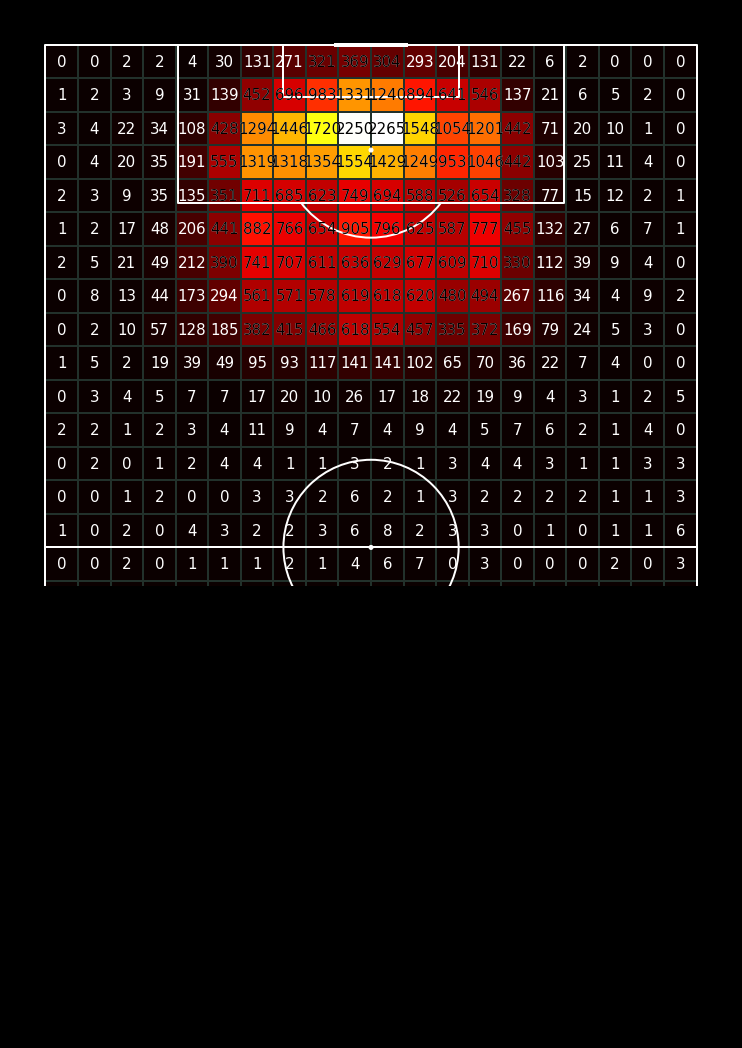

In [16]:
plt.style.use('dark_background')
pitch = VerticalPitch(pitch_type='uefa',half=True, line_zorder=2)
fig, ax = pitch.draw(figsize=(16, 12))
bs = pitch.bin_statistic(df_all_shots.x, df_all_shots.y, statistic='count', bins=(30, 20))
pcm = pitch.heatmap(bs, ax=ax, cmap='hot', edgecolors='#22312b')
bs['statistic'] = np.nan_to_num(bs['statistic'])
bs['statistic'] = (bs['statistic']).astype(np.int32)
annotation = pitch.label_heatmap(bs, color='white', fontsize=15, ax=ax, ha='center', va='center', zorder=3)
mask = bs['statistic'] > 300
bs['statistic'] = bs['statistic'].astype(str)
bs['statistic'][~mask] = ''
annotation = pitch.label_heatmap(bs, color='black', fontsize=15, ax=ax, ha='center', va='center', zorder=4)
fig.savefig(os.path.join(cwd, 'figures', '17_number_of_shots_by_location.png'),
            bbox_inches = 'tight', pad_inches = 0.2)

Create Shot Zones

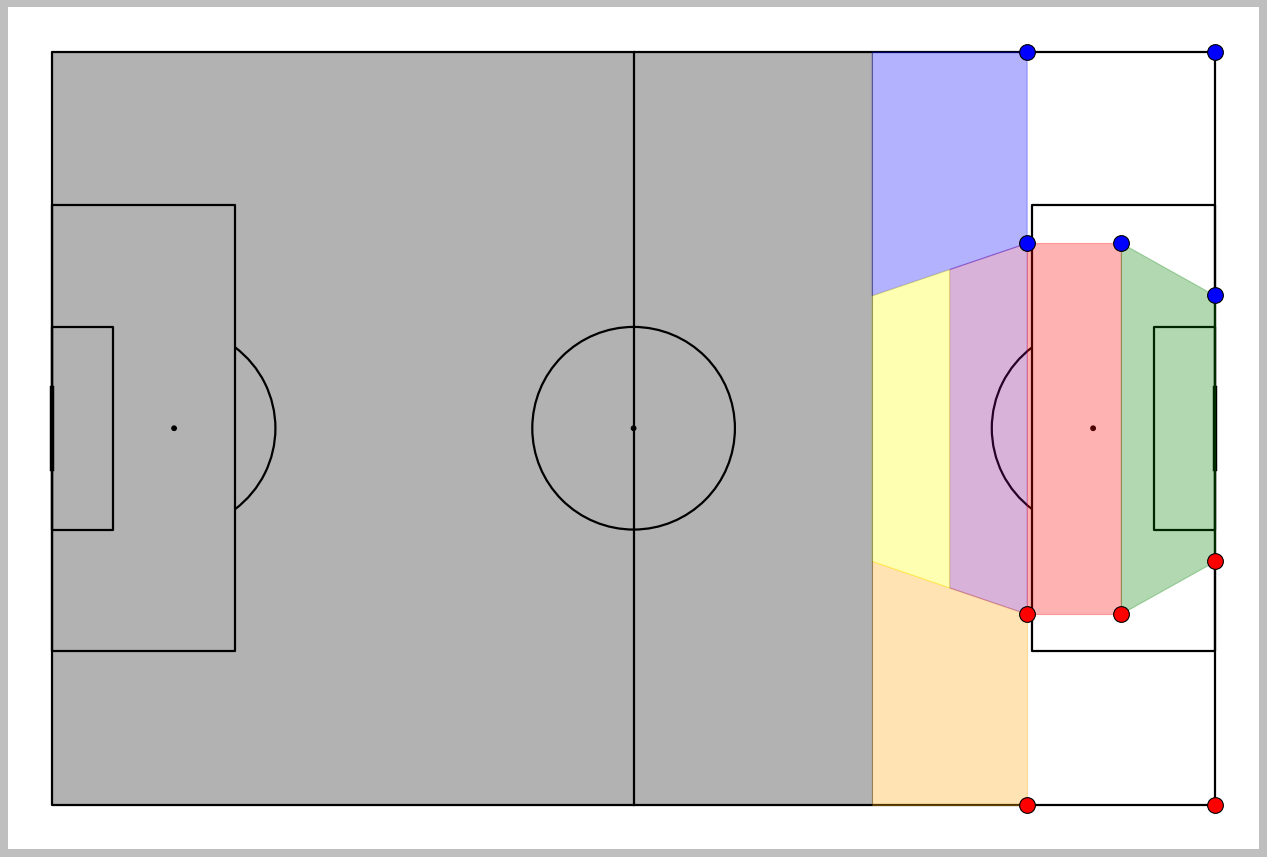

In [17]:
plt.style.use('classic')
pitch = Pitch(pitch_type='uefa')
fig, ax = pitch.draw(figsize=(16, 12))
z1 = np.array([[96.5,17.25],
                [105, 22],
                [105, 0],
                [88, 0],
                [88, 17.25]])
z2 = np.array([[96.5,50.75],
                [105, 46],
                [105, 68],
                [88, 68],
                [88, 50.75]])
z3 = np.array([[96.5, 50.75],
                [96.5, 17.25],
                [105, 22],
                [105, 46]])
z4 = np.array([[88, 50.75],
                [88, 17.25],
                [96.5, 17.25],
                [96.5, 50.75]])
z5 = np.array([[74, 22],
                [74, 0],
                [88, 0],
                [88, 17.25]])
z6 = np.array([[74, 46],
                [74, 68],
                [88, 68],
                [88, 50.75]])
z7 = np.array([[81, 48.375],
                [81, 19.625],
                [88, 17.25],
                [88, 50.75]])
z8 = np.array([[74, 46],
                [74, 22],
                [81, 19.625],
                [81, 48.375]])
z9 = np.array([[0, 68],
                [0, 0],
                [74, 0],
                [74, 68]])
hull = pitch.convexhull(z5[:,0], z5[:,1])
poly = pitch.polygon(hull, ax=ax, edgecolor='orange', facecolor='orange', alpha=0.3)
hull2 = pitch.convexhull(z4[:,0], z4[:,1])
poly = pitch.polygon(hull2, ax=ax, edgecolor='red', facecolor='red', alpha=0.3)
hull3 = pitch.convexhull(z3[:,0], z3[:,1])
poly = pitch.polygon(hull3, ax=ax, edgecolor='green', facecolor='green', alpha=0.3)
hull4 = pitch.convexhull(z6[:,0], z6[:,1])
poly = pitch.polygon(hull4, ax=ax, edgecolor='blue', facecolor='blue', alpha=0.3)
hull5 = pitch.convexhull(z7[:,0], z7[:,1])
poly = pitch.polygon(hull5, ax=ax, edgecolor='purple', facecolor='purple', alpha=0.3)
hull6 = pitch.convexhull(z8[:,0], z8[:,1])
poly = pitch.polygon(hull6, ax=ax, edgecolor='yellow', facecolor='yellow', alpha=0.3)
hull7 = pitch.convexhull(z9[:,0], z9[:,1])
poly = pitch.polygon(hull7, ax=ax, edgecolor='black', facecolor='black', alpha=0.3)
scatter = pitch.scatter(z1[:,0], z1[:,1], ax=ax, facecolor='red', s= 200)
scatter = pitch.scatter(z2[:,0], z2[:,1], ax=ax, facecolor='blue', s= 200)
z1 = geom.Polygon(z1)
z2 = geom.Polygon(z2)
z3 = geom.Polygon(z3)
z4 = geom.Polygon(z4)
z5 = geom.Polygon(z5)
z6 = geom.Polygon(z6)
z7 = geom.Polygon(z7)
z8 = geom.Polygon(z8)
z9 = geom.Polygon(z9)

Add Shot Zones to the DF Shots

In [18]:
shot_loc = geom.MultiPoint(df_all_shots[['x', 'y']].values)
z1_shot = [point.intersects(z1) for point in shot_loc]
z2_shot = [point.intersects(z2) for point in shot_loc]
z3_shot = [point.intersects(z3) for point in shot_loc]
z4_shot = [point.intersects(z4) for point in shot_loc]
z5_shot = [point.intersects(z5) for point in shot_loc]
z6_shot = [point.intersects(z6) for point in shot_loc]
z7_shot = [point.intersects(z7) for point in shot_loc]
z8_shot = [point.intersects(z8) for point in shot_loc]
z9_shot = [point.intersects(z9) for point in shot_loc]
df_all_shots['z1'] = z1_shot
df_all_shots['z2'] = z2_shot
df_all_shots['z3'] = z3_shot
df_all_shots['z4'] = z4_shot
df_all_shots['z5'] = z5_shot
df_all_shots['z6'] = z6_shot
df_all_shots['z7'] = z7_shot
df_all_shots['z8'] = z8_shot
df_all_shots['z9'] = z9_shot
df_all_shots.loc[(df_all_shots.z1 == True), 'shot_zone'] = 'Zone 1'
df_all_shots.loc[(df_all_shots.z2 == True), 'shot_zone'] = 'Zone 2'
df_all_shots.loc[(df_all_shots.z3 == True), 'shot_zone'] = 'Zone 3'
df_all_shots.loc[(df_all_shots.z4 == True), 'shot_zone'] = 'Zone 4'
df_all_shots.loc[(df_all_shots.z5 == True), 'shot_zone'] = 'Zone 5'
df_all_shots.loc[(df_all_shots.z6 == True), 'shot_zone'] = 'Zone 6'
df_all_shots.loc[(df_all_shots.z7 == True), 'shot_zone'] = 'Zone 7'
df_all_shots.loc[(df_all_shots.z8 == True), 'shot_zone'] = 'Zone 8'
df_all_shots.loc[(df_all_shots.z9 == True), 'shot_zone'] = 'Zone 9'
df_all_shots.drop(['z1', 'z2', 'z3','z4', 'z5', 'z6','z7', 'z8', 'z9'], axis=1, inplace=True)
df_all_shots

,match_id,statsbomb_id,eventSec,period,goal,statsbomb_team_id,player_id_statsbomb,shot_type_name,x,y,...,n_angle,goalkeeper_x,goalkeeper_y,dataset,wyscout_id,wyscout_team_id,player_id_wyscout,smart_pass,match_moment,shot_zone
0,68357,25875da2-cf9d-461f-a423-ef7806fa3603,0.400000,5.0,True,852.0,10386.0,penalty,94.5875,33.830,...,NaN,NaN,NaN,statsbomb,NaN,NaN,NaN,NaN,0-15,Zone 4
1,18243,85011ca9-6869-4a82-8101-8db06eb88d21,0.777000,5.0,True,220.0,5200.0,penalty,95.3750,33.150,...,NaN,NaN,NaN,statsbomb,NaN,NaN,NaN,NaN,0-15,Zone 4
2,2302764,2a8656c0-311f-4abc-b097-be10d19c3e0b,1.731000,5.0,False,243.0,34385.0,penalty,94.6750,33.915,...,NaN,NaN,NaN,statsbomb,NaN,NaN,NaN,NaN,0-15,Zone 4
3,7582,d077fefd-b6be-4992-92c8-ae347b6ab2f5,5.627000,5.0,True,772.0,5216.0,penalty,95.3750,33.150,...,NaN,NaN,NaN,statsbomb,NaN,NaN,NaN,NaN,0-15,Zone 4
4,7581,539170ab-d9f1-47e6-b4c4-d9a5fbf9599f,7.413000,5.0,False,776.0,3043.0,penalty,94.5000,34.000,...,NaN,NaN,NaN,statsbomb,NaN,NaN,NaN,NaN,0-15,Zone 4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43406,2499739,NaN,3310.186437,2.0,False,NaN,NaN,throw_in,91.3500,46.920,...,NaN,NaN,NaN,wyscout,182137485.0,1659.0,9277.0,None,75-90,Zone 4
43407,2499820,NaN,3307.255167,2.0,False,NaN,NaN,penalty,93.4500,34.000,...,NaN,NaN,NaN,wyscout,203362731.0,1644.0,7929.0,None,75-90,Zone 4
43408,2516750,NaN,3389.861176,2.0,False,NaN,NaN,open_play,92.4000,27.200,...,NaN,NaN,NaN,wyscout,182026562.0,2463.0,127685.0,False,75-90,Zone 4
43409,2499820,NaN,3446.055301,2.0,False,NaN,NaN,open_play,93.4500,20.400,...,NaN,NaN,NaN,wyscout,203362910.0,1623.0,145692.0,False,75-90,Zone 4


Add wich number of shot is any shot for:
    
* The team on an specific shot zone
* The player on an specific shot zone
* The team in general
* The player in general

In [19]:
df_all_shots['shot_number'] = df_all_shots.groupby(['match_id','team_id'])['minute'].rank(method="first", ascending=True)
df_all_shots['shot_zone_number'] = df_all_shots.groupby(['match_id','team_id','shot_zone'])['minute'].rank(method="first", ascending=True)
df_all_shots['shot_player_number'] = df_all_shots.groupby(['match_id','team_id','player_id'])['minute'].rank(method="first", ascending=True)
df_all_shots['shot_zone_player_number'] = df_all_shots.groupby(['match_id','team_id','player_id','shot_zone'])['minute'].rank(method="first", ascending=True)
df_all_shots['penalty_number'] = df_all_shots.groupby(['match_id','team_id','shot_type_name'])['minute'].rank(method="first", ascending=True)
df_all_shots

,match_id,statsbomb_id,eventSec,period,goal,statsbomb_team_id,player_id_statsbomb,shot_type_name,x,y,...,wyscout_team_id,player_id_wyscout,smart_pass,match_moment,shot_zone,shot_number,shot_zone_number,shot_player_number,shot_zone_player_number,penalty_number
0,68357,25875da2-cf9d-461f-a423-ef7806fa3603,0.400000,5.0,True,852.0,10386.0,penalty,94.5875,33.830,...,NaN,NaN,NaN,0-15,Zone 4,1.0,1.0,1.0,1.0,1.0
1,18243,85011ca9-6869-4a82-8101-8db06eb88d21,0.777000,5.0,True,220.0,5200.0,penalty,95.3750,33.150,...,NaN,NaN,NaN,0-15,Zone 4,1.0,1.0,1.0,1.0,1.0
2,2302764,2a8656c0-311f-4abc-b097-be10d19c3e0b,1.731000,5.0,False,243.0,34385.0,penalty,94.6750,33.915,...,NaN,NaN,NaN,0-15,Zone 4,1.0,1.0,1.0,1.0,1.0
3,7582,d077fefd-b6be-4992-92c8-ae347b6ab2f5,5.627000,5.0,True,772.0,5216.0,penalty,95.3750,33.150,...,NaN,NaN,NaN,0-15,Zone 4,1.0,1.0,1.0,1.0,1.0
4,7581,539170ab-d9f1-47e6-b4c4-d9a5fbf9599f,7.413000,5.0,False,776.0,3043.0,penalty,94.5000,34.000,...,NaN,NaN,NaN,0-15,Zone 4,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43406,2499739,NaN,3310.186437,2.0,False,NaN,NaN,throw_in,91.3500,46.920,...,1659.0,9277.0,None,75-90,Zone 4,9.0,4.0,1.0,1.0,1.0
43407,2499820,NaN,3307.255167,2.0,False,NaN,NaN,penalty,93.4500,34.000,...,1644.0,7929.0,None,75-90,Zone 4,11.0,5.0,1.0,1.0,1.0
43408,2516750,NaN,3389.861176,2.0,False,NaN,NaN,open_play,92.4000,27.200,...,2463.0,127685.0,False,75-90,Zone 4,17.0,3.0,2.0,1.0,14.0
43409,2499820,NaN,3446.055301,2.0,False,NaN,NaN,open_play,93.4500,20.400,...,1623.0,145692.0,False,75-90,Zone 4,9.0,5.0,2.0,1.0,5.0


In [20]:
df_all_shots = df_all_shots[df_all_shots.H_A_column.notnull()].copy()

In [21]:
df_all_shots.reset_index(drop=True, inplace=True)

Save data

In [22]:
df_all_shots.to_parquet(os.path.join(cwd, 'data', 'shots.parquet'))

Info

In [23]:
df_all_shots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65788 entries, 0 to 65787
Data columns (total 63 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   match_id                 65788 non-null  int64  
 1   statsbomb_id             22377 non-null  object 
 2   eventSec                 65788 non-null  float64
 3   period                   65788 non-null  float64
 4   goal                     65788 non-null  bool   
 5   statsbomb_team_id        22377 non-null  float64
 6   player_id_statsbomb      22377 non-null  float64
 7   shot_type_name           65788 non-null  object 
 8   x                        65788 non-null  float64
 9   y                        65788 non-null  float64
 10  counter_attack           65788 non-null  bool   
 11  fast_break               65788 non-null  bool   
 12  strong_foot              65788 non-null  bool   
 13  body_part_name           65788 non-null  object 
 14  assist_type           

Compare datasets

Text(0.5, 1.0, 'Wyscout')

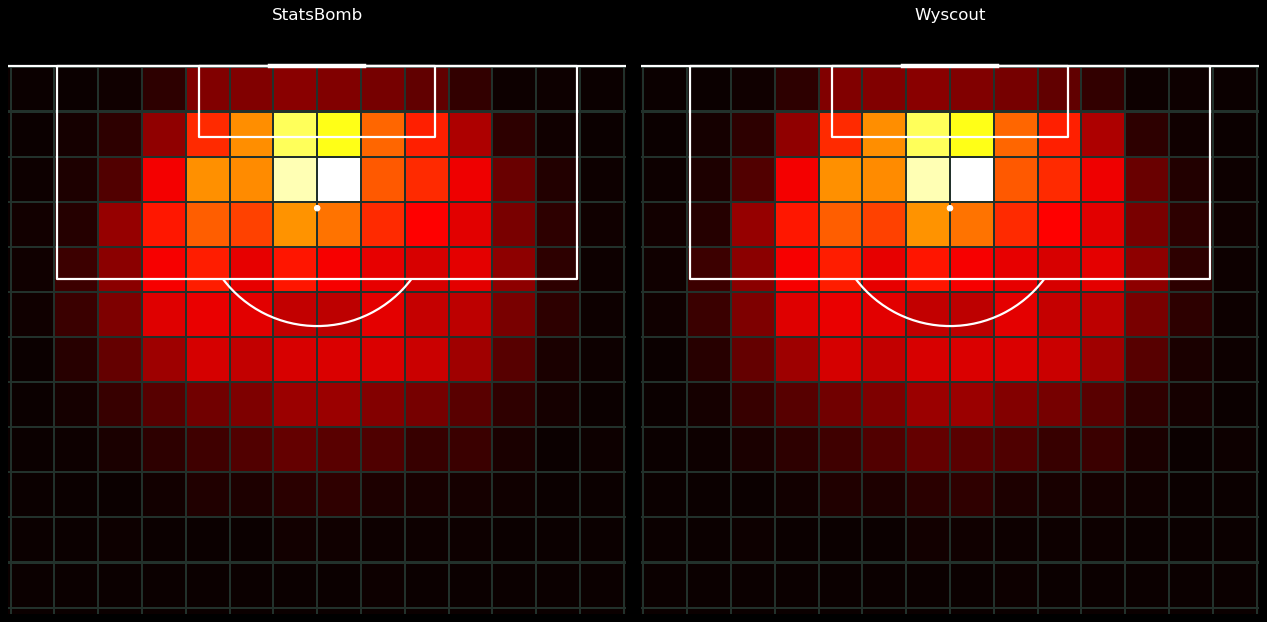

In [24]:
plt.style.use('dark_background')
pitch = VerticalPitch(pitch_type='uefa', layout=(1, 2), pad_left=-10, pad_right=-10, pad_bottom=-10,
              half=True, line_zorder=2)
fig, ax = pitch.draw(figsize=(16, 12),ncols=2)
ax = ax.ravel()
bs = pitch.bin_statistic(df_all_shots[df_all_shots.dataset=='statsbomb'].x,
                         df_all_shots[df_all_shots.dataset=='statsbomb'].y, 
                         statistic='count', bins=(30, 20))
bs['statistic'] = (bs['statistic']).astype(np.int32)
pcm = pitch.heatmap(bs, ax=ax[0], cmap='hot', edgecolors='#22312b')
ax[0].set_title('StatsBomb', fontsize=15, pad=-4)
bs['statistic'] = (bs['statistic']).astype(np.int32)
pcm = pitch.heatmap(bs, ax=ax[1], cmap='hot', edgecolors='#22312b')
ax[1].set_title('Wyscout', fontsize=15, pad=-4)

In [25]:
df_all_shots.groupby('dataset').fast_break.mean()

dataset
statsbomb    0.033114
wyscout      0.041533
Name: fast_break, dtype: float64

In [26]:
df_all_shots.groupby('dataset').counter_attack.mean()

dataset
statsbomb    0.045895
wyscout      0.051738
Name: counter_attack, dtype: float64

In [27]:
df_all_shots.groupby('dataset').visible_angle.describe()

,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
statsbomb,22377.0,0.469528,0.297422,0.0,0.275234,0.365817,0.578325,3.141593
wyscout,43411.0,0.408926,0.250888,0.0,0.247140,0.320078,0.502020,3.141593


In [28]:
df_all_shots.groupby('dataset').middle_angle.describe()

,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
statsbomb,22377.0,0.485665,0.331766,0.0,0.21261,0.452154,0.717564,1.570796
wyscout,43411.0,0.474607,0.313902,0.0,0.21261,0.445236,0.689349,1.570796


In [29]:
df_all_shots.groupby('dataset').distance_to_goal.describe()

,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
statsbomb,22377.0,16.638817,7.741455,0.6,10.5,15.7,22.2,70.8
wyscout,43411.0,18.929806,8.375183,0.7,12.5,17.7,25.5,75.4


In [30]:
df_all_shots.groupby('dataset').distance_visible_angle.describe()

,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
statsbomb,22377.0,6.109867,1.152068,0.0,5.616462,6.464079,6.976090,9.738937
wyscout,43411.0,6.180356,1.090191,0.0,5.725457,6.529107,7.007013,7.316065


In [31]:
df_all_shots.groupby('dataset').pass_switch.value_counts()

dataset    pass_switch
statsbomb  False          14663
           True            1007
wyscout    False          26483
           True            2062
Name: pass_switch, dtype: int64

In [32]:
df_all_shots.groupby('dataset').pass_cut_back.value_counts()

dataset    pass_cut_back
statsbomb  False            15252
           True               418
wyscout    False            27597
           True               948
Name: pass_cut_back, dtype: int64

In [33]:
df_all_shots.groupby('dataset').pass_cross.value_counts()

dataset    pass_cross
statsbomb  False         12674
           True           2996
wyscout    False         21182
           True           7363
Name: pass_cross, dtype: int64

In [34]:
df_all_shots.smart_pass.value_counts()

False    26185
True      2360
Name: smart_pass, dtype: int64

In [35]:
df_all_shots.groupby('dataset').assist_type.value_counts()

dataset    assist_type
statsbomb  pass           15670
           recovery        2332
           clearance       1787
           direct          1326
           rebound         1262
wyscout    pass           28545
           recovery        6529
           rebound         3356
           direct          2598
           clearance       2383
Name: assist_type, dtype: int64

In [36]:
df_all_shots.groupby('dataset').shot_type_name.value_counts()

dataset    shot_type_name  
statsbomb  open_play           14462
           corner               2611
           throw_in             2053
           free_kick            1575
           direct_set_piece     1326
           penalty               350
wyscout    open_play           29207
           corner               5274
           throw_in             4249
           free_kick            2083
           direct_set_piece     2051
           penalty               547
Name: shot_type_name, dtype: int64

In [37]:
df_all_shots.groupby('dataset').shot_zone.value_counts()

dataset    shot_zone
statsbomb  Zone 4        8413
           Zone 3        5939
           Zone 7        4510
           Zone 8        1947
           Zone 9         477
           Zone 6         352
           Zone 5         310
           Zone 1         222
           Zone 2         207
wyscout    Zone 4       16271
           Zone 3        8241
           Zone 8        6796
           Zone 7        6723
           Zone 9        1682
           Zone 6        1565
           Zone 5        1181
           Zone 2         569
           Zone 1         383
Name: shot_zone, dtype: int64

In [38]:
df_all_shots.groupby('dataset').shot_number.value_counts()

dataset    shot_number
statsbomb  1.0            1756
           2.0            1747
           3.0            1729
           4.0            1696
           5.0            1640
                          ... 
wyscout    35.0              3
           36.0              2
           37.0              2
           38.0              1
           39.0              1
Name: shot_number, Length: 84, dtype: int64

In [39]:
df_all_shots.groupby('dataset').shot_player_number.value_counts()

dataset    shot_player_number
statsbomb  1.0                   10919
           2.0                    5412
           3.0                    2805
           4.0                    1486
           5.0                     812
           6.0                     456
           7.0                     244
           8.0                     121
           9.0                      60
           10.0                     34
           11.0                     16
           12.0                      8
           13.0                      2
           14.0                      1
           15.0                      1
wyscout    1.0                   23606
           2.0                   10831
           3.0                    5039
           4.0                    2276
           5.0                     974
           6.0                     401
           7.0                     164
           8.0                      66
           9.0                      30
           10.0                   

In [40]:
df_all_shots.groupby('dataset').shot_zone_number.value_counts()

dataset    shot_zone_number
statsbomb  1.0                  7310
           2.0                  4729
           3.0                  3311
           4.0                  2342
           5.0                  1603
           6.0                  1113
           7.0                   721
           8.0                   461
           9.0                   292
           10.0                  177
           11.0                  116
           12.0                   72
           13.0                   45
           14.0                   29
           15.0                   21
           16.0                   13
           17.0                    9
           18.0                    6
           19.0                    1
           20.0                    1
           21.0                    1
           22.0                    1
           23.0                    1
           24.0                    1
           25.0                    1
wyscout    1.0                 16852
          

In [41]:
df_all_shots.groupby('dataset').shot_zone_player_number.value_counts()

dataset    shot_zone_player_number
statsbomb  1.0                        16975
           2.0                         3798
           3.0                         1112
           4.0                          339
           5.0                          105
           6.0                           28
           7.0                           11
           8.0                            5
           9.0                            2
           10.0                           1
           11.0                           1
wyscout    1.0                        35448
           2.0                         6197
           3.0                         1352
           4.0                          315
           5.0                           68
           6.0                           23
           7.0                            6
           8.0                            2
Name: shot_zone_player_number, dtype: int64